# Can the codon frequency be used to predict the DNAtype and Kingdom? This time using Deep Learning.
---
<b>MADS-DL Portfolio-Exam Part 2<br>
Janosch Höfer, 938969</b>

## Table of contents

- [Introduction](#intro) <br>
- [1. Data preparation](#data-prep) <br>
- [2. Parameters](#parameters) <br>
- [3. Split Data](#split) <br>
- [4. Model setup and Hyperparameter Optimization](#model-setup) <br>
   - [4.1. Neural Network](#NN) <br>
   - [4.2. Cross-validation](#CV) <br>
- [5. Model Evaluation](#eval) <br>
   - [5.1. Codon-Kingdom](#eval-king) <br>
   - [5.2. Codon-DNAtype](#eval-dna) <br>
- [6. Result](#result)<br>
- [References](#ref)<br>

## Introduction

In [73]:
# Standard libraries
import copy
import logging
import os
import random
from datetime import timedelta
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn.functional as F
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

# Own classes and functions
from neuralnet import NeuralNet, load_best_model
from utils import DataModule, compute_metrics

In [74]:
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [75]:
RANDOM_SEED = 42
pl.seed_everything(RANDOM_SEED, workers=True)

42

In [76]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

---
<a id='data-prep'></a>

## 1. Data preparation

In [77]:
data_raw = pd.read_csv("data/codon_usage.csv", sep=",")

C:\Users\j56857\AppData\Local\Temp\ipykernel_22948\3303151036.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv("data/codon_usage.csv", sep=",")


In [78]:
# I removed the steps to identify the invalid rows to make the code more concise
# The CSV indices start at 1, while pandas start 0
bad_rows = [
    data_raw[data_raw["UUU"] == "non-B hepatitis virus"].index[0] + 1,
    data_raw[data_raw["UUU"] == "12;I"].index[0] + 1,
]
data_raw = pd.read_csv("data/codon_usage.csv", sep=",", skiprows=bad_rows)

In [79]:
kingdom = data_raw["Kingdom"]
np.sort(kingdom.unique()), kingdom.unique().size

(array(['arc', 'bct', 'inv', 'mam', 'phg', 'plm', 'pln', 'pri', 'rod',
        'vrl', 'vrt'], dtype=object),
 11)

In [80]:
data_king = data_raw.copy(deep=True)

In [81]:
condition = []
choices = []
# Setup conditions and choices
for count, key in enumerate(kingdom.unique()):
    condition.append(data_raw["Kingdom"] == key)  # unique kingdom 3-letter codes
    choices.append(count)  # integer now assigned to kingdom

data_king["Kingdom_num"] = np.select(condition, choices)
data_king.groupby("Kingdom_num").count()

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
Kingdom_num,,,,,,,,,,,,,,,,,,,,,
0,2831,2831,2831,2831,2831,2831,2831,2831,2831,2831,...,2831,2831,2831,2831,2831,2831,2831,2831,2831,2831
1,126,126,126,126,126,126,126,126,126,126,...,126,126,126,126,126,126,126,126,126,126
2,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,...,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919
3,220,220,220,220,220,220,220,220,220,220,...,220,220,220,220,220,220,220,220,220,220
4,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
5,2523,2523,2523,2523,2523,2523,2523,2523,2523,2523,...,2523,2523,2523,2523,2523,2523,2523,2523,2523,2523
6,1345,1345,1345,1345,1345,1345,1345,1345,1345,1345,...,1345,1345,1345,1345,1345,1345,1345,1345,1345,1345
7,2077,2077,2077,2077,2077,2077,2077,2077,2077,2077,...,2077,2077,2077,2077,2077,2077,2077,2077,2077,2077
8,572,572,572,572,572,572,572,572,572,572,...,572,572,572,572,572,572,572,572,572,572


In [82]:
labels = ["Kingdom_num"]
complete_data = data_king.iloc[:, 5:]
final_data = data_king.iloc[:, 5:].drop(labels, axis=1)
targets = data_king.loc[:, labels]

---
<a id='parameters'></a>

## 2. Parameters

In [83]:
# Parameters
feature_n = final_data.shape[1]
classes_n = len(targets.drop_duplicates(subset=labels))
num_epochs = 75
test_size = 0.3
val_size = 0.2
core_n = psutil.cpu_count(logical=False)
if core_n > 1:
    core_n = core_n - 1

---
<a id='split'></a>

## 3. Split Data

In [84]:
DF_train_full, DF_test = train_test_split(
    complete_data,
    test_size=test_size,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=targets,
)

In [85]:
DF_train, DF_val, = train_test_split(
    DF_train_full,
    test_size=val_size,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=DF_train_full[labels],
)

In [86]:
df_dict = {"train": DF_train, "val": DF_val, "test": DF_test}
for key, df_ in df_dict.items():
    print(f"{key}_data:\t size {df_.shape[0]:>3}")

train_data:	 size 7294
val_data:	 size 1824
test_data:	 size 3908


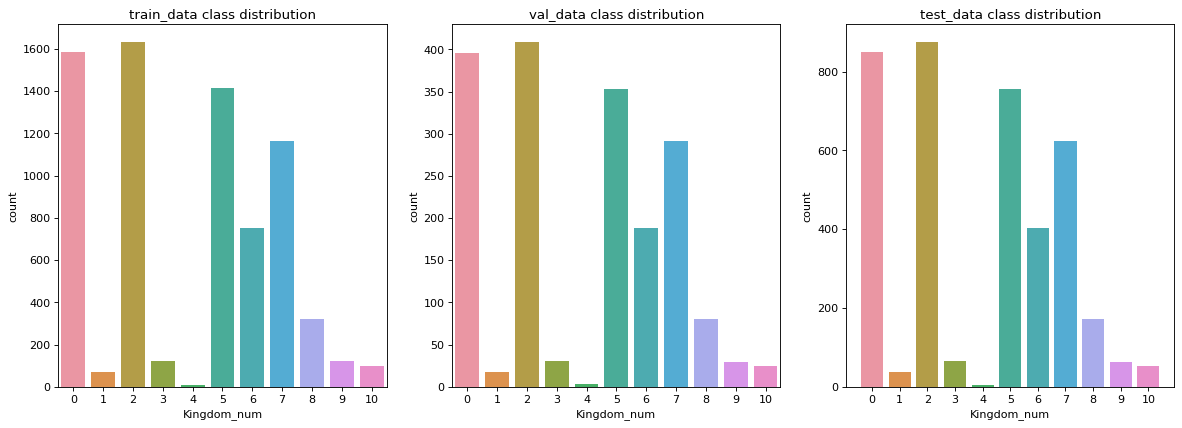

In [87]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=80)
for ax, (key, df_) in enumerate(df_dict.items()):
    sns.countplot(data=df_, x=labels[0], ax=axes[ax])
    axes[ax].set(title=f"{key}_data class distribution")
    plt.plot()

---
<a id='model-setup'></a>

## 4. Model setup and Hyperparameter Optimization
<a id='NN'></a>
### 4.1 Neural Network

In [16]:
%load_ext tensorboard
%tensorboard --logdir ./logs/ --host localhost

In [88]:
def train_codons(
    df_train,
    df_val,
    df_test,
    layer_count,
    lr,
    batch_size,
    num_epochs=10,
    core_n=1,
    weights=None,
    dev=False,
    cv=None,
    stop=15,
):
    pl.seed_everything(RANDOM_SEED, workers=True)
    data_module = DataModule(
        train_df=df_train,
        test_df=df_test,
        val_df=df_val,
        classes=labels,
        num_workers=core_n,
        batch_size=batch_size,
        device=device,
    )
    model = NeuralNet(
        feature_n, classes_n, lr, layer_count=layer_count, weights=weights, device=device
    )
    if weights is not None:
        w_ind = True
    else:
        w_ind = False
    logger = TensorBoardLogger(
        save_dir="logs",
        name="DL-Exam2",
        version=f"layer={layer_count}-lr={lr}-batchsize={batch_size}-cv={cv}-weights={w_ind}",
    )
    checkpoint_callback = ModelCheckpoint(
        filename="best-checkpoint",
        save_top_k=1,
        monitor="val_loss",
        mode="min",
    )
    stop_callback = EarlyStopping(monitor="val_loss", mode="min", verbose=False, patience=stop)
    callbacks = [checkpoint_callback, stop_callback]
    if device.type == "cuda":
        cuda_kwargs = {"accelerator": "gpu", "devices": 1}
    else:
        cuda_kwargs = dict()
    trainer = pl.Trainer(
        max_epochs=num_epochs,
        logger=logger,
        log_every_n_steps=20,
        callbacks=callbacks,
        fast_dev_run=dev,
        enable_progress_bar=False,
        enable_model_summary=False,
        **cuda_kwargs,
    )
    trainer.fit(model, data_module)
    params = {
            "hidden_layer": layer_count,
            "learning_rate": lr,
            "batch_size": batch_size,
            "fold": cv,
            "weights": w_ind,
        }
    if dev:
        return {**params}
    else:
        version = (
            f"layer={layer_count}-"
            f"lr={lr}-"
            f"batchsize={batch_size}-"
            f"cv={cv}-"
            f"weights={w_ind}"
        )
        ckpt_path = f"logs/DL-Exam2/{version}/checkpoints/best-checkpoint.ckpt"
        val_res = trainer.validate(datamodule=data_module, verbose=False, ckpt_path=ckpt_path)
        test_res = trainer.test(datamodule=data_module, verbose=False, ckpt_path=ckpt_path)
        
        return {**params, **val_res[0], **test_res[0]}

In [89]:
def hp_optimization(config, df_train, df_val, df_test, num_epochs, dev=False, cv=None, stop=15):
    runs = list()
    param_count = 0
    for zdx in range(len(config["hidden_layer"])):
        for xdx in range(len(config["learning_rate"])):
            for ydx in range(len(config["batch_size"])):
                for wdx in range(len(config["weights"])):
                    layer_count = config["hidden_layer"][zdx]
                    lr = config["learning_rate"][xdx]
                    batch_size = config["batch_size"][ydx]
                    weights = config["weights"][wdx]
                    if weights is not None:
                        w_ind = True
                    else:
                        w_ind = False
                    start = timer()
                    runs.append(
                        train_codons(
                            df_train=df_train,
                            df_val=df_val,
                            df_test=df_test,
                            layer_count=layer_count,
                            lr=lr,
                            batch_size=batch_size,
                            num_epochs=num_epochs,
                            core_n=core_n,
                            weights=weights,
                            dev=dev,
                            cv=cv,
                            stop=stop,
                        )
                    )
                    param_count += 1
                    model_train_time = timer() - start
                    print(
                        f"Finished training of the HP-combination: {param_count:02d} - fold: {cv}\n"
                        f"Trained on hidden layers: {layer_count:>2} learning-rate: {lr:.4f} batch-size: {batch_size:>3} weights:{w_ind}\n"
                        f"Training time: {str(timedelta(seconds=model_train_time))}"
                    )
    return runs

In [90]:
def combine_to_df(left_array, right_array, labels):
    df = pd.merge(
        pd.DataFrame(left_array).iloc[:, :-1],
        right_array.reset_index().drop(columns="index")[labels],
        left_index=True,
        right_index=True,
    )
    return df

<a id='CV'></a>
### 4.2 Cross-Validation

Before the final crossvalidation configuration used in this notebook, many more combinations have been tested. Those can be observed in the tensorboard below.

The number of hidden layers did not change the result significantly.

The best batch size was 32.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./logs/ --host localhost

In [91]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [92]:
king_weights = compute_class_weight(
    class_weight="balanced",
    classes=targets.drop_duplicates(subset=labels).iloc[:, 0],
    y=targets.iloc[:, 0].ravel(),
)
king_weights_t = torch.Tensor(king_weights)

In [22]:
config = {
    "hidden_layer": [3],
    "learning_rate": [1e-2, 1e-3],
    "batch_size": [32],
    "weights": [None, king_weights_t],
}
runs_cv = list()
for idx, (train_index, val_index) in enumerate(
    skf.split(DF_train_full.drop(columns=labels), DF_train_full[labels])
):
    X_train, X_val = DF_train_full.iloc[train_index], DF_train_full.iloc[val_index]
    scaler = MinMaxScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_val_sc = scaler.transform(X_val)
    X_test_sc = scaler.transform(DF_test)  # Using initial DF_test because it stays the same

    DF_train_sc = combine_to_df(X_train_sc, X_train, labels)
    DF_val_sc = combine_to_df(X_val_sc, X_val, labels)
    DF_test_sc = combine_to_df(X_test_sc, DF_test, labels)
    runs_cv += hp_optimization(
        config,
        df_train=DF_train_sc,
        df_val=DF_val_sc,
        df_test=DF_test_sc,
        num_epochs=num_epochs,
        dev=True,
        cv=idx,
    )

Finished training of the HP-combination: 01 - fold: 0
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size:  32 weights:False
Training time: 0:20:03.328330
Finished training of the HP-combination: 02 - fold: 0
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size:  32 weights:True
Training time: 0:18:41.850020
Finished training of the HP-combination: 03 - fold: 0
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:False
Training time: 0:21:41.359757
Finished training of the HP-combination: 04 - fold: 0
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:True
Training time: 0:26:09.494430
Finished training of the HP-combination: 01 - fold: 1
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size:  32 weights:False
Training time: 0:27:06.826410
Finished training of the HP-combination: 02 - fold: 1
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size:  32 weights:True
Training time: 0:24:44.547659
Finished trai

In [23]:
pd.DataFrame(runs_cv).head()

,hidden_layer,learning_rate,batch_size,fold,weights,val_loss,val_accuracy,val_balanced_accuracy,val_f1,val_precision,test_loss,test_accuracy,test_balanced_accuracy,test_f1,test_precision
0,3,0.010,32,0,False,0.364653,0.887061,0.785621,0.763508,0.768643,0.366787,0.893040,0.789152,0.775044,0.783994
1,3,0.010,32,0,True,0.677569,0.841009,0.725070,0.715859,0.738026,0.600965,0.854913,0.740960,0.731187,0.752108
2,3,0.001,32,0,False,0.366146,0.893092,0.775272,0.764258,0.777636,0.339268,0.899181,0.781771,0.772663,0.787708
3,3,0.001,32,0,True,0.533058,0.845943,0.738198,0.718292,0.735226,0.501688,0.857472,0.742690,0.730539,0.752187
4,3,0.010,32,1,False,0.294161,0.925439,0.835346,0.826959,0.833148,0.357994,0.907881,0.816360,0.804748,0.816199


In [93]:
cv_hp_result_df = pd.read_parquet(path="data/cv_hp_optimization", engine="pyarrow")

In [94]:
cv_hp_results_mean = (
    cv_hp_result_df.groupby(["hidden_layer", "learning_rate", "batch_size", "weights"])
    .mean()
    .reset_index()
)

In [95]:
cv_hp_results_mean

,hidden_layer,learning_rate,batch_size,weights,fold,val_loss,val_accuracy,val_balanced_accuracy,val_f1,val_precision,test_loss,test_accuracy,test_balanced_accuracy,test_f1,test_precision
0,3,0.001,32,False,2.0,0.304006,0.909411,0.815393,0.802284,0.809738,0.329518,0.907830,0.812485,0.801086,0.811714
1,3,0.001,32,True,2.0,0.501618,0.861813,0.759732,0.744256,0.758825,0.539139,0.859570,0.740209,0.730578,0.751791
2,3,0.010,32,False,2.0,0.323522,0.902610,0.802563,0.785433,0.791734,0.355281,0.901279,0.802465,0.789046,0.798774
3,3,0.010,32,True,2.0,0.614015,0.845579,0.728503,0.713392,0.733938,0.595307,0.848158,0.719609,0.709367,0.731486


In [97]:
cv_hp_results_mean[cv_hp_results_mean["val_balanced_accuracy"] > 0.8].sort_values(
    ["val_balanced_accuracy", "val_accuracy"], ascending=False
)

,hidden_layer,learning_rate,batch_size,weights,fold,val_loss,val_accuracy,val_balanced_accuracy,val_f1,val_precision,test_loss,test_accuracy,test_balanced_accuracy,test_f1,test_precision
0,3,0.001,32,False,2.0,0.304006,0.909411,0.815393,0.802284,0.809738,0.329518,0.907830,0.812485,0.801086,0.811714
2,3,0.010,32,False,2.0,0.323522,0.902610,0.802563,0.785433,0.791734,0.355281,0.901279,0.802465,0.789046,0.798774


In [98]:
best_params = cv_hp_results_mean[
    cv_hp_results_mean["val_balanced_accuracy"] == cv_hp_results_mean["val_balanced_accuracy"].max()
]
best_params

,hidden_layer,learning_rate,batch_size,weights,fold,val_loss,val_accuracy,val_balanced_accuracy,val_f1,val_precision,test_loss,test_accuracy,test_balanced_accuracy,test_f1,test_precision
0,3,0.001,32,False,2.0,0.304006,0.909411,0.815393,0.802284,0.809738,0.329518,0.90783,0.812485,0.801086,0.811714


---
<a id='eval'></a>

## 5. Model Evaluation
<a id='eval-king'></a>
### 5.1 Kingdom prediction

In [99]:
best_config = best_params.iloc[:1, :].to_dict("list")

In [100]:
# Parameters
feature_n = final_data.shape[1]
classes_n = len(targets.drop_duplicates(subset=labels))
num_epochs = 100  # Now using more epochs
test_size = 0.3
val_size = 0.2
core_n = psutil.cpu_count(logical=False)
if core_n > 1:
    core_n = core_n - 1

In [101]:
if best_params["weights"].iloc[0]:
    king_weights = compute_class_weight(
        class_weight="balanced",
        classes=targets.drop_duplicates(subset=labels).iloc[:, 0],
        y=targets.iloc[:, 0].ravel(),
    )
    best_config["weights"] = [torch.Tensor(king_weights)]
else:
    best_config["weights"] = [None]

In [102]:
skf_eval = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

In [103]:
runs_eval = list()
king_data = dict()
for idx, (train_index, test_index) in enumerate(
    skf_eval.split(complete_data.drop(columns=labels), complete_data[labels])
):
    X_train_full, X_test = complete_data.iloc[train_index], complete_data.iloc[test_index]
    X_train, X_val, = train_test_split(
        X_train_full,
        test_size=val_size,
        shuffle=True,
        random_state=RANDOM_SEED,
        stratify=X_train_full[labels],
    )
    scaler = MinMaxScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_val_sc = scaler.fit_transform(X_val)
    X_test_sc = scaler.transform(X_test)

    DF_train_sc = combine_to_df(X_train_sc, X_train, labels)
    DF_val_sc = combine_to_df(X_val_sc, X_val, labels)
    DF_test_sc = combine_to_df(X_test_sc, X_test, labels)
    runs_eval += hp_optimization(
        best_config,
        df_train=DF_train_sc,
        df_val=DF_val_sc,
        df_test=DF_test_sc,
        num_epochs=num_epochs,
        dev=True,
        cv=f"final_king_{idx}",
    )
    king_data[f"final_king_{idx}"] = [DF_train_sc, DF_val_sc, DF_test_sc]

Finished training of the HP-combination: 01 - fold: final_king_0
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:False
Training time: 0:19:28.228068
Finished training of the HP-combination: 01 - fold: final_king_1
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:False
Training time: 0:22:02.069045
Finished training of the HP-combination: 01 - fold: final_king_2
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:False
Training time: 0:12:24.188310


In [104]:
pd.DataFrame(runs_eval).head()

,hidden_layer,learning_rate,batch_size,fold,weights,val_loss,val_accuracy,val_balanced_accuracy,val_f1,val_precision,test_loss,test_accuracy,test_balanced_accuracy,test_f1,test_precision
0,3,0.001,32,final_king_0,False,0.546111,0.829591,0.683223,0.668798,0.691307,0.624125,0.815292,0.296840,0.311527,0.338345
1,3,0.001,32,final_king_1,False,0.534724,0.852044,0.723126,0.700653,0.705484,0.605306,0.835560,0.322901,0.337125,0.361204
2,3,0.001,32,final_king_2,False,1.055881,0.672999,0.555563,0.511980,0.532778,0.984014,0.684017,0.232463,0.261313,0.306260


In [106]:
eval_king_result_df = pd.read_parquet(path="data/eval_king", engine="pyarrow")

In [107]:
eval_king_result_df

,hidden_layer,learning_rate,batch_size,fold,weights,val_loss,val_accuracy,val_balanced_accuracy,val_f1,val_precision,test_loss,test_accuracy,test_balanced_accuracy,test_f1,test_precision
0,3,0.001,32,final_king_0,False,0.546111,0.829591,0.683223,0.668798,0.691307,0.624125,0.815292,0.296840,0.311527,0.338345
1,3,0.001,32,final_king_1,False,0.534724,0.852044,0.723126,0.700653,0.705484,0.605306,0.835560,0.322901,0.337125,0.361204
2,3,0.001,32,final_king_2,False,1.055881,0.672999,0.555563,0.511980,0.532778,0.984014,0.684017,0.232463,0.261313,0.306260


In [108]:
best_model_key = "final_king_1"
best_config = best_params.iloc[:1, :].to_dict("list")
best_model = load_best_model(
    best_config,
    NeuralNet,
    feature_n=feature_n,
    classes_n=classes_n,
    device=device,
    cv=best_model_key,
)
king_res = list()
for key, items in king_data.items():
    if key == best_model_key:
        for res_list in items:
            king_res.append(
                compute_metrics(
                    best_model,
                    torch.tensor(res_list.drop(columns=labels).values, dtype=torch.float),
                    res_list[labels],
                )
            )

In [109]:
pd.DataFrame(king_res)

,accuracy,balanced_accuracy,f1,precision,confusion_matrix
0,0.925723,0.690560,0.712224,0.864504,"[[1451, 2, 6, 0, 0, 30, 17, 2, 0, 0, 1], [1, 3..."
1,0.852044,0.588380,0.592641,0.669076,"[[353, 0, 1, 0, 0, 5, 15, 4, 0, 0, 0], [3, 6, ..."
2,0.835560,0.588749,0.598296,0.732422,"[[840, 0, 1, 0, 0, 20, 58, 22, 0, 0, 3], [13, ..."


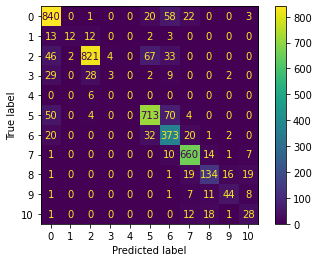

In [110]:
ConfusionMatrixDisplay(king_res[-1]["confusion_matrix"]).plot()
plt.show()

<a id='eval-dna'></a>
### 5.2 DNAtype prediction

In [111]:
dnatype = data_raw["DNAtype"]
np.sort(dnatype.unique()), dnatype.unique().size

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 11, 12], dtype=int64), 11)

In [112]:
data_dna = data_raw.copy(deep=True)

In [113]:
condition = []
choices = []
# Setup conditions and choices
for count, key in enumerate(dnatype.unique()):
    condition.append(data_raw["DNAtype"] == key)  # unique kingdom 3-letter codes
    choices.append(count)  # integer now assigned to kingdom

data_dna["DNAtype_num"] = np.select(condition, choices)
data_dna.groupby("DNAtype_num").count()

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
DNAtype_num,,,,,,,,,,,,,,,,,,,,,
0,9265,9265,9265,9265,9265,9265,9265,9265,9265,9265,...,9265,9265,9265,9265,9265,9265,9265,9265,9265,9265
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,31,31,31,31,31,31,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31
3,816,816,816,816,816,816,816,816,816,816,...,816,816,816,816,816,816,816,816,816,816
4,2899,2899,2899,2899,2899,2899,2899,2899,2899,2899,...,2899,2899,2899,2899,2899,2899,2899,2899,2899,2899
5,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
6,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
7,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
8,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [114]:
data_drop_dna = data_dna[data_dna["DNAtype"].isin([0, 1, 2, 4])]
data_raw[~data_raw["DNAtype"].isin([0, 1, 2, 4])].count()

Kingdom        15
DNAtype        15
SpeciesID      15
Ncodons        15
SpeciesName    15
               ..
GAA            15
GAG            15
UAA            15
UAG            15
UGA            15
Length: 69, dtype: int64

In [115]:
labels = ["DNAtype_num"]
complete_data = data_drop_dna.iloc[:, 5:]
targets = data_drop_dna.loc[:, labels]
classes_n = len(targets.drop_duplicates(subset=labels))

In [116]:
DF_train_full, DF_test = train_test_split(
    complete_data,
    test_size=test_size,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=targets,
)
DF_train, DF_val, = train_test_split(
    DF_train_full,
    test_size=val_size,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=DF_train_full[labels],
)

In [117]:
df_dict = {"train": DF_train, "val": DF_val, "test": DF_test}
for key, df_ in df_dict.items():
    print(f"{key}_data:\t size {df_.shape[0]:>3}")

train_data:	 size 7285
val_data:	 size 1822
test_data:	 size 3904


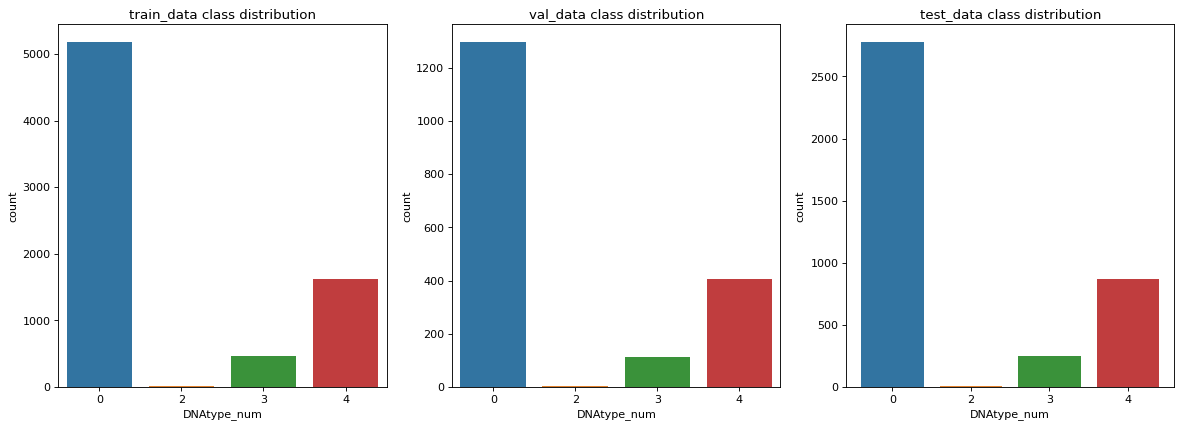

In [118]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=80)
for ax, (key, df_) in enumerate(df_dict.items()):
    sns.countplot(data=df_, x=labels[0], ax=axes[ax])
    axes[ax].set(title=f"{key}_data class distribution")
    plt.plot()

In [119]:
# Adjust labels
complete_data[labels] = np.where(complete_data[labels] == 4, 1, complete_data[labels])
targets = complete_data.loc[:, labels]

In [120]:
# Parameters
feature_n = final_data.shape[1]
classes_n = len(targets.drop_duplicates(subset=labels))
num_epochs = 100  # Now using more epochs
test_size = 0.3
val_size = 0.2
core_n = psutil.cpu_count(logical=False)
if core_n > 1:
    core_n = core_n - 1

In [121]:
best_params

,hidden_layer,learning_rate,batch_size,weights,fold,val_loss,val_accuracy,val_balanced_accuracy,val_f1,val_precision,test_loss,test_accuracy,test_balanced_accuracy,test_f1,test_precision
0,3,0.001,32,False,2.0,0.304006,0.909411,0.815393,0.802284,0.809738,0.329518,0.90783,0.812485,0.801086,0.811714


In [122]:
if best_params["weights"].iloc[0]:
    dna_weights = compute_class_weight(
        class_weight="balanced",
        classes=targets.drop_duplicates(subset=labels).iloc[:, 0],
        y=targets.iloc[:, 0].ravel(),
    )
    best_config["weights"] = [torch.Tensor(dna_weights)]
else:
    best_config["weights"] = [None]

In [123]:
runs_eval = list()
dna_data = dict()
for idx, (train_index, test_index) in enumerate(
    skf_eval.split(complete_data.drop(columns=labels), complete_data[labels])
):
    X_train_full, X_test = complete_data.iloc[train_index], complete_data.iloc[test_index]
    X_train, X_val, = train_test_split(
        X_train_full,
        test_size=val_size,
        shuffle=True,
        random_state=RANDOM_SEED,
        stratify=X_train_full[labels],
    )
    scaler = MinMaxScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_val_sc = scaler.fit_transform(X_val)
    X_test_sc = scaler.transform(X_test)

    DF_train_sc = combine_to_df(X_train_sc, X_train, labels)
    DF_val_sc = combine_to_df(X_val_sc, X_val, labels)
    DF_test_sc = combine_to_df(X_test_sc, X_test, labels)
    runs_eval += hp_optimization(
        best_config,
        df_train=DF_train_sc,
        df_val=DF_val_sc,
        df_test=DF_test_sc,
        num_epochs=num_epochs,
        dev=False,
        cv=f"final_dna_{idx}",
        stop=50,
    )
    dna_data[f"final_dna_{idx}"] = [DF_train_sc, DF_val_sc, DF_test_sc]

Finished training of the HP-combination: 01 - fold: final_dna_0
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:False
Training time: 0:34:32.919255
Finished training of the HP-combination: 01 - fold: final_dna_1
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:False
Training time: 0:35:30.307616
Finished training of the HP-combination: 01 - fold: final_dna_2
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size:  32 weights:False
Training time: 0:32:51.845010


In [124]:
pd.DataFrame(runs_eval).head()

,hidden_layer,learning_rate,batch_size,fold,weights,val_loss,val_accuracy,val_balanced_accuracy,val_f1,val_precision,test_loss,test_accuracy,test_balanced_accuracy,test_f1,test_precision
0,3,0.001,32,final_dna_0,False,0.031147,0.991354,0.962560,0.957022,0.955122,0.043187,0.989855,0.945814,0.944967,0.946736
1,3,0.001,32,final_dna_1,False,0.037342,0.993084,0.970738,0.964828,0.963065,0.020102,0.994236,0.956227,0.955625,0.956138
2,3,0.001,32,final_dna_2,False,0.037790,0.992507,0.959373,0.957211,0.957435,0.068758,0.986166,0.957110,0.959087,0.966584


In [125]:
pd.DataFrame(runs_eval).to_parquet(path="data/eval_dna", engine="pyarrow")

In [126]:
eval_dna_result_df = pd.read_parquet(path="data/eval_dna", engine="pyarrow")

In [127]:
eval_dna_result_df

,hidden_layer,learning_rate,batch_size,fold,weights,val_loss,val_accuracy,val_balanced_accuracy,val_f1,val_precision,test_loss,test_accuracy,test_balanced_accuracy,test_f1,test_precision
0,3,0.001,32,final_dna_0,False,0.031147,0.991354,0.962560,0.957022,0.955122,0.043187,0.989855,0.945814,0.944967,0.946736
1,3,0.001,32,final_dna_1,False,0.037342,0.993084,0.970738,0.964828,0.963065,0.020102,0.994236,0.956227,0.955625,0.956138
2,3,0.001,32,final_dna_2,False,0.037790,0.992507,0.959373,0.957211,0.957435,0.068758,0.986166,0.957110,0.959087,0.966584


In [128]:
best_model_key = "final_dna_1"
best_config = best_params.iloc[:1, :].to_dict("list")
best_model = load_best_model(
    best_config,
    NeuralNet,
    feature_n=feature_n,
    classes_n=classes_n,
    device=device,
    cv=best_model_key,
)

In [129]:
dna_res = list()
for key, items in dna_data.items():
    if key == best_model_key:
        for res_list in items:
            dna_res.append(
                compute_metrics(
                    best_model,
                    torch.tensor(res_list.drop(columns=labels).values, dtype=torch.float),
                    res_list[labels],
                )
            )

In [130]:
pd.DataFrame(dna_res)

,accuracy,balanced_accuracy,f1,precision,confusion_matrix
0,0.994668,0.743633,0.742341,0.988090,"[[4939, 1, 0, 2], [10, 1536, 0, 0], [4, 1, 0, ..."
1,0.993084,0.744959,0.739726,0.979649,"[[1231, 2, 0, 2], [2, 384, 0, 1], [1, 0, 0, 3]..."
2,0.994236,0.745641,0.741049,0.982154,"[[3081, 4, 0, 3], [3, 962, 0, 1], [1, 1, 0, 9]..."


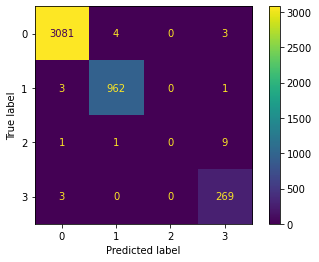

In [131]:
ConfusionMatrixDisplay(dna_res[-1]["confusion_matrix"]).plot()
plt.show()

---
<a id='result'></a>

## 6. Result